Pronóstico de la cantidad de usuarios que acceden a un servidor de internet usando un ADALINE --- 20:16 min
===

* Última modificación: Marzo 21, 2020 | [YouTube](https://youtu.be/YQkFsykOx7k)

In [1]:
import warnings

warnings.filterwarnings("ignore")

En la práctica es común realizar el pronóstico de series de tiempo que exhiben comportamientos no lineales mediante modelos lineales cuyos parámetros que cambian en el tiempo. En esta lección, voy a presentar como usar un tipo de red neuronal llamado combinador lineal adaptativo o ADALINE para realizar pronósitcos. Este modelo es el precursor de los modelos TDNN (time delay neural networks) y fue ampliamente utilizado en la solución de problemas reales durante los años 70.

## Definición del problema

Se desea construir un modelo para pronósticar la cantidad de usuarios que acceden a un servidor de internet por minuto. La muestra de datos obtenida corresponde a 100 minutos consecutivos. Los primeros 80 datos deben ser usados para la estimación del modelo, y los 20 restantes para su predicción (simulando el uso del modelo en productivo). 

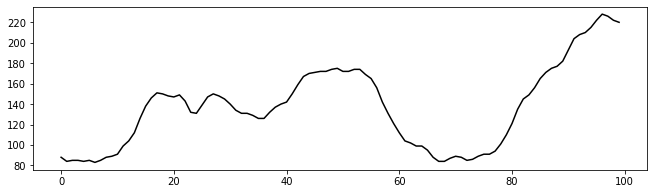

In [2]:
import matplotlib.pyplot as plt

d = [
     88,  84,  85,  85,  84,  85,  83,  85,  88,  89,
     91,  99, 104, 112, 126, 138, 146, 151, 150, 148,
    147, 149, 143, 132, 131, 139, 147, 150, 148, 145,
    140, 134, 131, 131, 129, 126, 126, 132, 137, 140,
    142, 150, 159, 167, 170, 171, 172, 172, 174, 175,
    172, 172, 174, 174, 169, 165, 156, 142, 131, 121,
    112, 104, 102,  99,  99,  95,  88,  84,  84,  87,
     89,  88,  85,  86,  89,  91,  91,  94, 101, 110,
    121, 135, 145, 149, 156, 165, 171, 175, 177, 182,
    193, 204, 208, 210, 215, 222, 228, 226, 222, 220,
    ]

plt.figure(figsize=(11,3))
plt.plot(d, '-k');

## Análisis exploratorio

El modelo a utilizar es el siguiente:

$$z_{t} = w_0 + w_1 z_{t-1} + ... + w_P z_{t-P}$$

Para determinar el orden apropiado del modelo $P$, se utiliza la función de autocorrelación (ACF) que indica la dependencia entre $z_t$ y $z_{t-k}$. Esta está definida como:

$$
\text{acf}(k) = \frac{1}{T-k} \sum (z_{t+k} - \bar{z})(z_t - \bar{z})
$$

donde:

$$
\bar{z} = \frac{1}{T} \sum_t z_t
$$

En la siguiente celda, se realiza el cómputo de la ACF para la muestra de entrenamiento. 

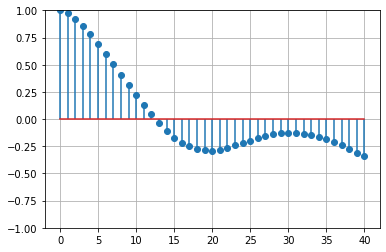

In [3]:
from statsmodels.tsa.stattools import acf

acf_data = acf(d[0:80], fft=False)
plt.stem(range(len(acf_data)), acf_data, use_line_collection=True)
plt.ylim(-1, 1);
plt.grid();

La forma de la ACF es típica de series de tiempo no estacionarias. Una serie de tiempo es estacionaria si su media y su varianza no cambian en el tiempo. De la gráfica de la serie de tiempo se observa que la primera mitad tiene una media diferente a la de la segunda mitad. 

En estas situaciones, se crea una nueva serie $u_t$ que se obtiene mediante la diferenciación de la serie original:

$$
u_t = z_t - z_{t-1}
$$

In [4]:
import numpy as np

u = np.array(d[1:len(d)]) - np.array(d[0:len(d) - 1])

La serie obtenida es la siguiente:

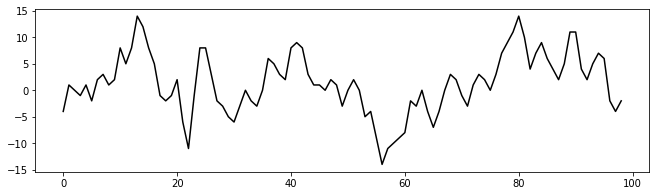

In [5]:
plt.figure(figsize=(11,3))
plt.plot(u, '-k');

Note que esta serie si es estacionaria.

Se recomputa la ACF:

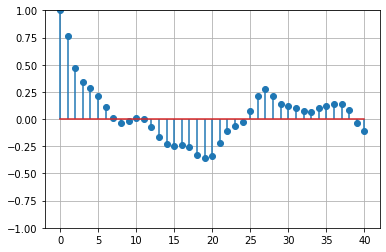

In [6]:
acf_data = acf(u[0:79], fft=False)
plt.stem(range(len(acf_data)), acf_data, use_line_collection=True)
plt.ylim(-1, 1)
plt.grid();

En un primer análisis podría seleccionarse a $P=6$. Sin embargo, es necesario recurrir a la función de autocorrelación parcial (PACF) antes de tomar esta decisión.

La PACF permite estimar la dependencia entre $z_{t+k}$ y $z_t$ eliminando las dependencias causadas por $z_{t+k-1}, ..., z_{t+1}$. La explicación es la siguiente: suponga un modelo con $P=1$:

$$
z_t = \phi z_{t-1}
$$

Entonces puede decirse que:

$$
\begin{split}
z_t & = \phi z_{t-1} \\
    & = \phi (\phi z_{t-2}) = \phi^2 z_{t-2}  \\
    & ... \\
    & = \phi^t z_0
\end{split}
$$

entonces, aunque solo hay dependencia real entre $z_t$ y su valor anterior $z_{t-1}$, el resultado muestra que la ACF indicará dependencia para $k=1, 2, ..., t$. Entonces la PACF elimina las dependencias para $k=1,..., t-1$.

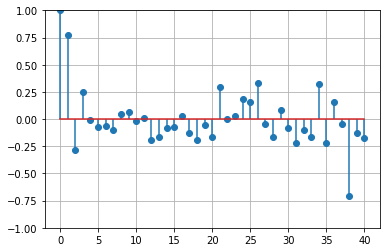

In [7]:
from statsmodels.tsa.stattools import pacf

pacf_data = pacf(u[0:79])
plt.stem(range(len(pacf_data)), pacf_data, use_line_collection=True)
plt.ylim(-1, 1);
plt.grid();

El resultado anterior muestra que el valor máximo sería $P=3$.

El valor óptimo de la tasa de aprendizaje debe obtenerse mediante tanteo y error.

In [8]:
#
# Implementación usada en el tutorial anterior
#
class AdalineTS:
    
    def __init__(self, 
                 P=None,               # número de retardos a usar
                 learning_rate=0.001): # tasa de aprendizaje
        
        self.P = P
        self.learning_rate = learning_rate
        self.X = []        
        self.coef_ = [0.] * P
        self.intercept_ = 0.        
        
    def predict(self):
        if len(self.X) < self.P:
            return None
        X = np.array(self.X)        
        u = np.dot(X, self.coef_) + self.intercept_
        return u       
        
    def fit(self, d):
        y = self.predict()
        if y is not None:
            e = d - y
            self.coef_ += 2 * self.learning_rate * e * np.array(self.X)
            self.intercept_ += 2 * self.learning_rate * e 
        self.X.append(d)
        if len(self.X) > self.P:
            self.X.pop(0)

In [9]:
#
# variables para almacenar la tasa de aprendizaje optima
#
optimal_learning_rate = None
optimal_sse = None

P = 3

for learning_rate in np.linspace(start=0.000001, stop=0.01, num=100):

    adaline = AdalineTS(
        P=P,
        learning_rate=learning_rate)

    forecasts = []

    for z in u[0:79]:
        forecasts.append(adaline.predict())
        adaline.fit(z)
    
    sse = sum([(a-b)**2 for a,b in zip(u[P:79], forecasts[P:])])
    
    if optimal_sse is None or sse < optimal_sse:
        optimal_sse = sse
        optimal_learning_rate = learning_rate
        print('sse = {}  mu = {}'.format(sse, learning_rate))
 

sse = 2264.1348784077254  mu = 1e-06
sse = 1737.1771479476201  mu = 0.00010200000000000001
sse = 1531.5222599983279  mu = 0.00020300000000000003
sse = 1420.3548837220615  mu = 0.00030400000000000007
sse = 1345.5085490078686  mu = 0.0004050000000000001
sse = 1288.6064860546376  mu = 0.000506
sse = 1242.5677656436392  mu = 0.0006070000000000001
sse = 1204.1777961078083  mu = 0.0007080000000000002
sse = 1171.757565289291  mu = 0.0008090000000000001
sse = 1144.3084054315045  mu = 0.0009100000000000001
sse = 1121.1629459698959  mu = 0.001011
sse = 1101.8332035755714  mu = 0.0011120000000000001
sse = 1085.9419826518067  mu = 0.001213
sse = 1073.1916640759414  mu = 0.001314
sse = 1063.3511335415274  mu = 0.0014150000000000002
sse = 1056.2529847696464  mu = 0.0015160000000000002
sse = 1051.798389375061  mu = 0.0016170000000000002
sse = 1049.9697929801175  mu = 0.0017180000000000001


In [10]:
#
# Se hace nuevamente el modelo para todos los datos
#
adaline = AdalineTS(
    P=P,
    learning_rate=optimal_learning_rate)

forecasts = []

for z in u:
    forecasts.append(adaline.predict())
    adaline.fit(z)
  

Para poder graficar el pronóstico es necesario integrar la serie (operación inversa a la diferenciación).

$$
z_t = z_{t-1} + u_t
$$

donde $u_t$ es el pronóstico.

In [11]:
s = [m + n for m,n in zip(d[P:len(d)-1], forecasts[P:])]
s = d[0:P+1] + s
len(s)

100

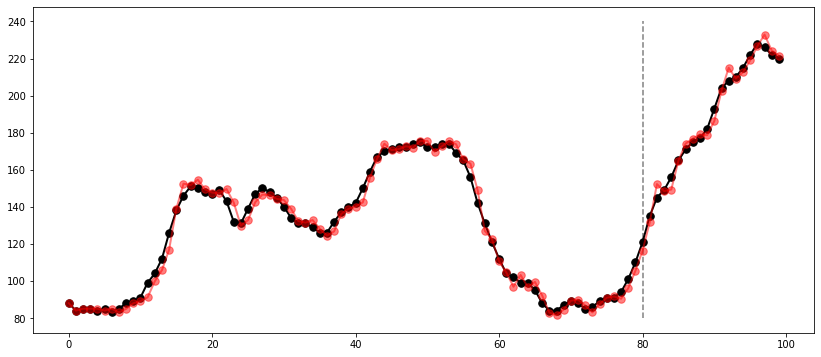

In [40]:
plt.figure(figsize=(14,6))
plt.plot(d,'.-k', lw=2, ms=15)
plt.plot(s, '.-r', lw=2, ms=15, alpha=0.5)
plt.vlines([80], ls='--', color='gray', ymin=80, ymax=240)
plt.show()

In [13]:
# cómputo del MSE
mse_fit = sum([(a - b)**2 for a,b in zip(d[4:80], s[4:80])]) / len(s[4:80])
mse_fore = sum([(a - b)**2 for a,b in zip(d[80:], s[80:])]) / len(s[80:])
print(mse_fit, mse_fore)

13.815392012896282 16.286727152892198


**Ejercicio.---** ¿El modelo podría mejorar si se usan otros valores diferentes para $P$?

**Ejercicio.---** ¿Qué pasa si se pronostica directamente la serie sin realizar la diferenciación?